# Programmer: Giovanni Vecchione
## Date: 3/8/24

## Subject: Project 3
Use convolutional neural network to build the project on the dataset of your choice. Submit your project as Jupyter notebook.

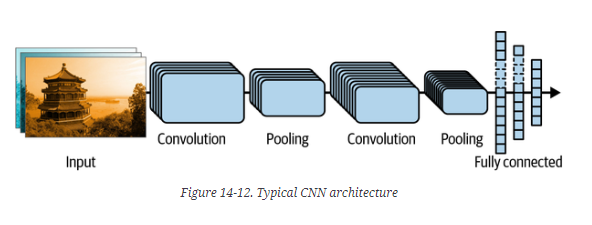

In [1]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

#import and preprocess sample images using Scikit-Learn's load_sample_image() funciton
#and Keras's CenterCrop and Rescaling layers.
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

images.shape

ModuleNotFoundError: No module named 'sklearn'